# Imports

In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, Conv2D, Rescaling, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Reading the dataset

In [2]:
DATA_DIR = 'data'

In [3]:
# Setting the train and test directory path
TRAIN_DIR_PATH = os.path.join(DATA_DIR, 'training_set')
TEST_DIR_PATH = os.path.join(DATA_DIR, 'test_set')

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (160,160)

In [5]:
# Getting the train and test dataset into tensorflow batches
train_batches = tf.keras.utils.image_dataset_from_directory(TRAIN_DIR_PATH,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE,
                                                            shuffle=True,
                                                            seed=123)

valid_test_batches = tf.keras.utils.image_dataset_from_directory(directory=TEST_DIR_PATH,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMAGE_SIZE,
                                                          shuffle=True,
                                                          seed=123)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


# Plotting some images

Wall time: 557 ms


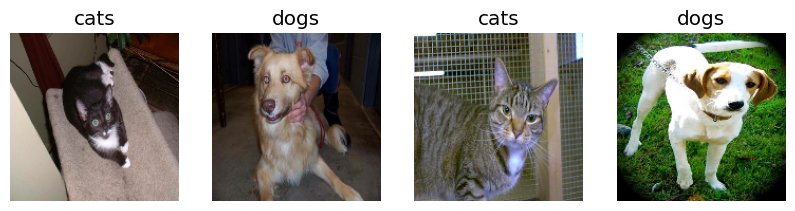

In [6]:
%%time
class_names = train_batches.class_names
plt.figure(figsize=(10,10))
for images, labels in train_batches.take(1):
    for i in range(4):
        ax = plt.subplot(1,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

# Train test split

In [7]:
validation_batches = tf.data.experimental.cardinality(valid_test_batches)
test_batches = valid_test_batches.take(validation_batches//5)
val_batches = valid_test_batches.skip(validation_batches//5)

In [8]:
print(f'No. of batches in Validation dataset: {len(test_batches)}')
print(f'No. of batches in Test dataset: {len(val_batches)}')

No. of batches in Validation dataset: 12
No. of batches in Test dataset: 52


# Configure dataset for performance

In [9]:
# Performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_batches.prefetch(buffer_size=AUTOTUNE)
val_ds = val_batches.prefetch(buffer_size=AUTOTUNE)
test_ds = test_batches.prefetch(buffer_size=AUTOTUNE)

# Data augmentation

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomRotation(factor=0.5)
])

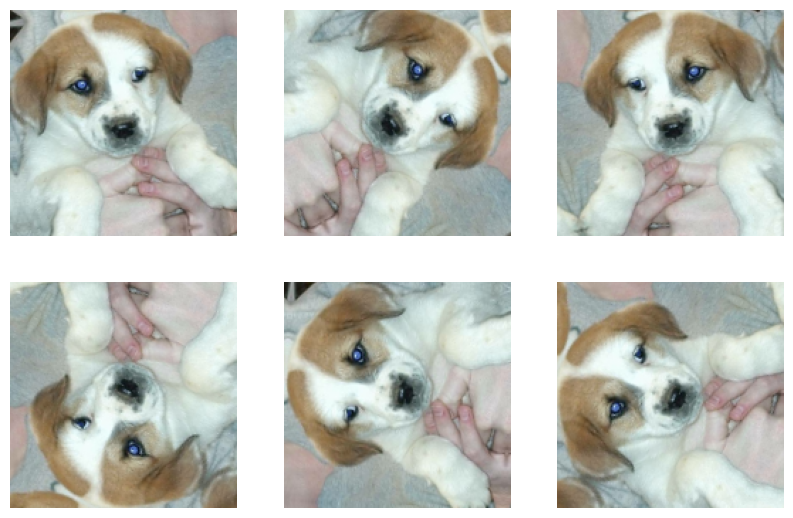

In [11]:
for images, _ in train_ds.take(1):
    first_image = images[0]
    plt.figure(figsize=(10,10))
    for i in range(6):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image,0))
        plt.imshow(augmented_image[0]/255)
        plt.axis('off')

# Building deep learning model

In [12]:
# Rescaling pixel values
rescaling = Rescaling(1.0/255)
train_ds = train_ds.map(lambda x, y: (rescaling(x), y))
valid_ds = val_ds.map(lambda x, y: (rescaling(x), y))
test_ds = test_ds.map(lambda x, y: (rescaling(x), y))

In [13]:
INPUT_SHAPE = IMAGE_SIZE + (3,)

In [14]:
# Initializing model and adding layers
model = Sequential()
model.add(Input(shape=INPUT_SHAPE))
model.add(data_augmentation)
model.add(Conv2D(filters=16, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=16, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #learning_rate=0.0001
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 158, 158, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 16)       

In [17]:
# Getting the intermediate layer output, here getting the rescaling output
# intermediate_layer = model.layers[0]
# seq = Sequential(intermediate_layer)
# seq.predict(train_dataset.take(1)).min()


# Training

In [18]:
EPOCHS = 10
CALLBACKS = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, mode='auto')
]

In [19]:
%%time
hist = model.fit(train_ds, 
                 epochs=EPOCHS,
                 validation_data=valid_ds,
                 callbacks=CALLBACKS)

Epoch 1/10
251/251 [==============================] - 228s 883ms/step - loss: 0.6909 - accuracy: 0.5362 - val_loss: 0.6730 - val_accuracy: 0.5930
Epoch 2/10
251/251 [==============================] - 219s 869ms/step - loss: 0.6576 - accuracy: 0.6072 - val_loss: 0.6364 - val_accuracy: 0.6339
Epoch 3/10
251/251 [==============================] - 217s 861ms/step - loss: 0.6275 - accuracy: 0.6503 - val_loss: 0.6170 - val_accuracy: 0.6669
Epoch 4/10
251/251 [==============================] - 214s 852ms/step - loss: 0.6108 - accuracy: 0.6677 - val_loss: 0.5998 - val_accuracy: 0.6888
Epoch 5/10
251/251 [==============================] - 214s 852ms/step - loss: 0.5960 - accuracy: 0.6778 - val_loss: 0.6031 - val_accuracy: 0.6760
Epoch 6/10
251/251 [==============================] - 215s 855ms/step - loss: 0.5901 - accuracy: 0.6858 - val_loss: 0.6002 - val_accuracy: 0.6730
Epoch 7/10
251/251 [==============================] - 214s 851ms/step - loss: 0.5828 - accuracy: 0.6934 - val_loss: 0.5794 -

# Plotting the loss and accuracy

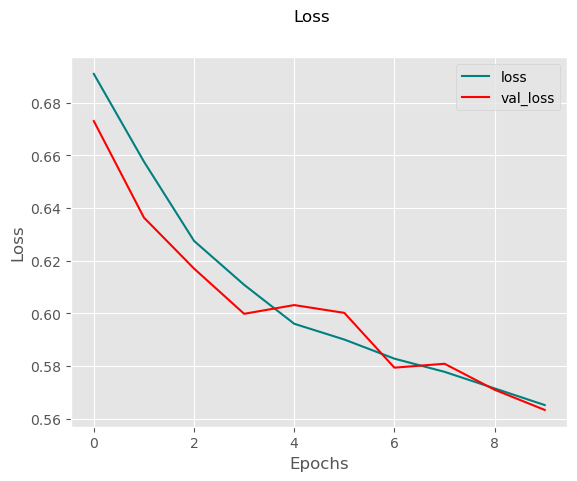

In [20]:
# Plotting the training loss and validation loss
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='red', label='val_loss')
plt.suptitle('Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

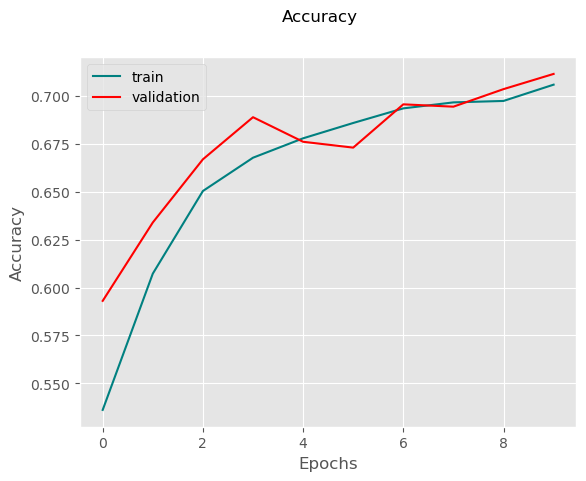

In [21]:
# Plotting the training accuracy and validation accuracy
plt.plot(hist.history['accuracy'], color='teal', label='train')
plt.plot(hist.history['val_accuracy'], color='red', label='validation')
plt.suptitle('Accuracy')
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Evaluating the accuracy

In [22]:
# Evaluating the test_dataset
train_accuracy = model.evaluate(train_ds, verbose=0)[1]
test_accuracy = model.evaluate(test_ds, verbose=0)[1]
print(f'Train Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy : {test_accuracy:.2f}')

Train Accuracy: 0.70
Test Accuracy : 0.71


In [23]:
# Predicting on a batch
image_batch, label_batch = test_ds.as_numpy_iterator().next()
pred = model.predict_on_batch(images).flatten()
pred = tf.where(pred < 0.5, 0, 1)

In [24]:
print(f'Labels:\n {label_batch}')
print(f'Predictions:\n {pred.numpy()}')

Labels:
 [0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1]
Predictions:
 [0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1]


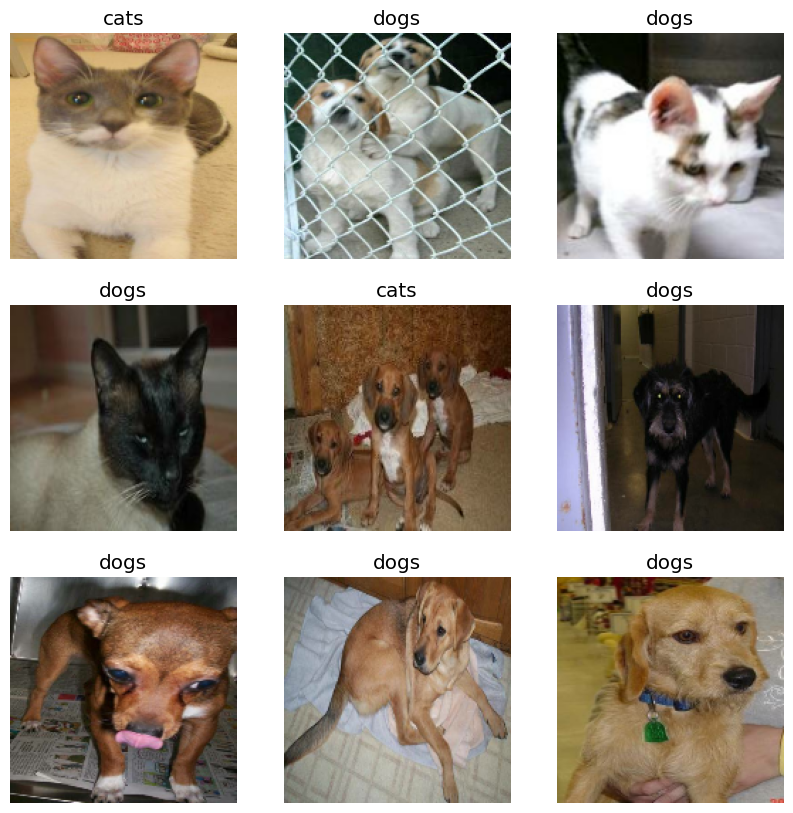

In [25]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title(class_names[pred[i]])
  plt.axis("off")

In [26]:
# Getting images and labels for testing
X_test, y_test = next(iter(test_ds))
for img, lbl in iter(test_ds):
    X_test = np.append(X_test, img, axis=0)
    y_test = np.append(y_test, lbl, axis=0)

In [27]:
# Predicting on test dataset
y_hat = model.predict(X_test)
y_hat = tf.where(y_hat < 0.5, 0, 1)

13/13 [==============================] - 3s 213ms/step


In [28]:
# Classification report
print(classification_report(y_test, y_hat, target_names=['Cat','Dog']))

              precision    recall  f1-score   support

         Cat       0.71      0.80      0.75       208
         Dog       0.77      0.67      0.72       208

    accuracy                           0.74       416
   macro avg       0.74      0.74      0.73       416
weighted avg       0.74      0.74      0.73       416



In [29]:
f1_score(y_test, y_hat)

0.7164948453608248

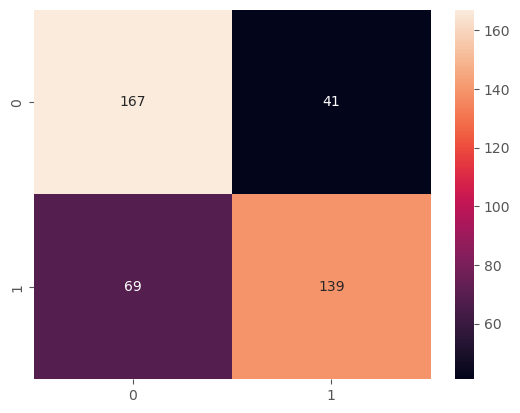

In [30]:
cf_matrix = confusion_matrix(y_test, y_hat)
_ = sns.heatmap(cf_matrix, annot=True, fmt='g')

# Save Model

In [31]:
model.save(os.path.join('model','catdogclassifier.h5'))

In [32]:
new_model = load_model(os.path.join('model', 'catdogclassifier.h5'))

In [33]:
img = plt.imread('pug.jpg')
print(f'Original size: {img.shape}')
img = tf.image.resize(img, IMAGE_SIZE)
print(f'Resized size: {img.shape}')

Original size: (1000, 1500, 3)
Resized size: (160, 160, 3)


In [34]:
new_model.predict(np.expand_dims(rescaling(img),0))

1/1 [==============================] - 0s 151ms/step


array([[0.9843594]], dtype=float32)